<a href="https://colab.research.google.com/github/TBFY/general/blob/master/notebooks/TBFY_Repositories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TheyBuyForYou Tools

Let's learn more about the tools developed by TBFY. 

We're going to use the [Github API](https://developer.github.com/v3/) to collect some statistics from the repositories:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import requests
from io import StringIO


token = '4f43878ae41fb1b4e4980568ce0eea921d48b3e6'
headers = {'Authorization': 'token ' + token}

repos_resp = requests.get('https://api.github.com/orgs/TBFY/repos', headers=headers)
if repos_resp.status_code != 200:
    raise ApiError('GET /repos/ {}'.format(repos_resp.status_code))
repos = repos_resp.json()
print('{} repositories are available'.format(len(repos)))

print('collecting statistics...')
repos_stats={}
for repo in repos:
  name = repo['name']
  repos_stats[name]= requests.get('https://api.github.com/repos/TBFY/'+name+'/stats/contributors', headers=headers).json()

repos_info={}
for repo in repos:
  name = repo['name']
  repos_info[name]= requests.get('https://api.github.com/repos/TBFY/'+name, headers=headers).json()
  
repos_download={}
for repo in repos:
  name = repo['name']
  repos_download[name]= requests.get('https://api.github.com/repos/TBFY/'+name+'/downloads', headers=headers).json()

  
print("statistics saved")  

20 repositories are available
collecting statistics...
statistics saved


## Repositories

Now, we have the necessary information to know a little more about each of the tools:


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)


names = [repo['name'] for repo in repos]  
descriptions = [repo['description'] for repo in repos]  
languages = [repo['language'] for repo in repos]  
sizes = [repo['size'] for repo in repos]
issues = [ repo['open_issues_count'] for repo in repos]
forks = [ repo['forks'] for repo in repos]
licenses = [repos_info[repo['name']]['license'] for repo in repos]
license_names = [ 'none' if license is None else license['key'] for license in licenses ]

dates = [repo['created_at'] for repo in repos]  

repo_dict = {'name': names, 'description': descriptions, '#issues': issues, '#forks': forks, 'language': languages, 'size(kb)': sizes, 'license': license_names, 'created_at': dates}  
    
repo_df = pd.DataFrame(repo_dict)

repo_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,name,description,#issues,#forks,language,size(kb),license,created_at
0,general,This repository will be used to manage all the projects/epics and stories that will be handled in the project,0,0,None,400,apache-2.0,2018-03-05T15:13:25Z
1,knowledge-graph,This is the repository where all the work towards the creation of the TheyBuyForYou knowledge graph will be done,15,7,Python,51578,apache-2.0,2018-03-05T15:29:56Z
2,crosslinguality,This repository is focused on the work done towards automatic real-time monitoring and analysis of public spending information published in different languages,1,2,Python,44,apache-2.0,2018-03-08T09:59:37Z
3,storytelling,This is the repository related to human-data interface concepts and components,3,1,JavaScript,1015,mit,2018-03-08T10:02:11Z
4,edp-economic-data-portal,Economic Information for a City Council. Repository where we will work on the ZGZ business case.,20,1,Jupyter Notebook,51,none,2018-06-11T11:46:49Z
5,bmbv-better-markets-better-value,Repository where we will work on the OO private business case.,12,1,Jupyter Notebook,93,apache-2.0,2018-07-17T09:30:12Z
6,knowledge-graph-API,This repository is dedicated to the core API of the TheyBuyForYou project built on top of R4R (https://github.com/TBFY/r4r),3,1,Jupyter Notebook,526,none,2019-01-23T16:24:20Z
7,ocds-ontology,Repository for the OCDS ontology that is being developed in the TBFY project,3,2,None,208,apache-2.0,2019-02-08T10:21:22Z
8,harvester,Download articles and legal documents on public procurement.,0,1,JavaScript,1641,apache-2.0,2019-02-20T17:22:18Z
9,search-API,explore large multilingual documentary collections from their semantics,1,0,JavaScript,2778,apache-2.0,2019-05-23T12:54:48Z


## Activity

The number of **opened issues** and **commits** in the last year could be used to know the the activity of a project:

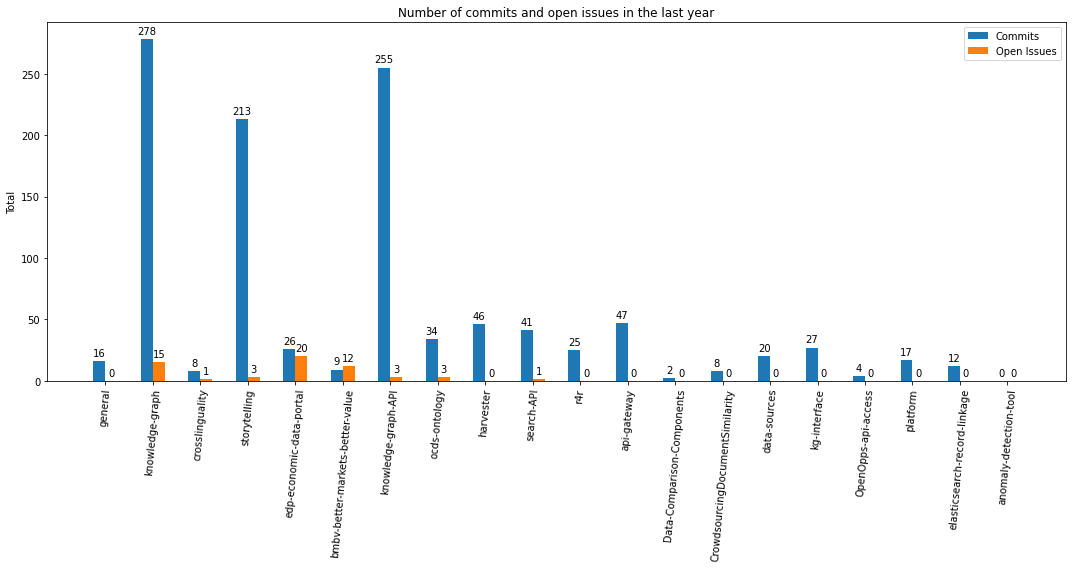

In [3]:
labels = [repo['name'] for repo in repos]
commits_last_year = [ sum(stats['total'] for stats in repos_stats[repo['name']]) for repo in repos]
open_issues = [ repo['open_issues_count'] for repo in repos]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, commits_last_year, width, label='Commits')
rects2 = ax.bar(x + width/2, open_issues, width, label='Open Issues')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total')
ax.set_title('Number of commits and open issues in the last year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=85)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.set_figwidth(15)
fig.set_figheight(8)
fig.tight_layout()

plt.show()

## Licenses

How the tools can be used will depend on the associated license:

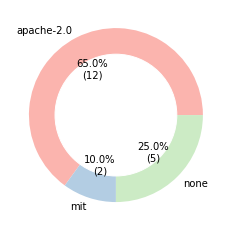

In [4]:
from itertools import groupby
licenses = [repos_info[repo['name']]['license'] for repo in repos]
license_names = [ 'none' if license is None else license['key'] for license in licenses ]
license_names.sort()
license_repo = [[key,len(list(group))] for key, group in groupby(license_names)]
names = [key for key,size in license_repo]
sizes = [size for key,size in license_repo]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
  
# Create a circle for the center of the plot
from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(sizes, labels=names, colors=Pastel1_7.hex_colors, autopct=lambda pct: func(pct, sizes))
p=plt.gcf()
p.gca().add_artist(plt.Circle( (0,0), 0.7, color='white'))
plt.show()



## Popularity

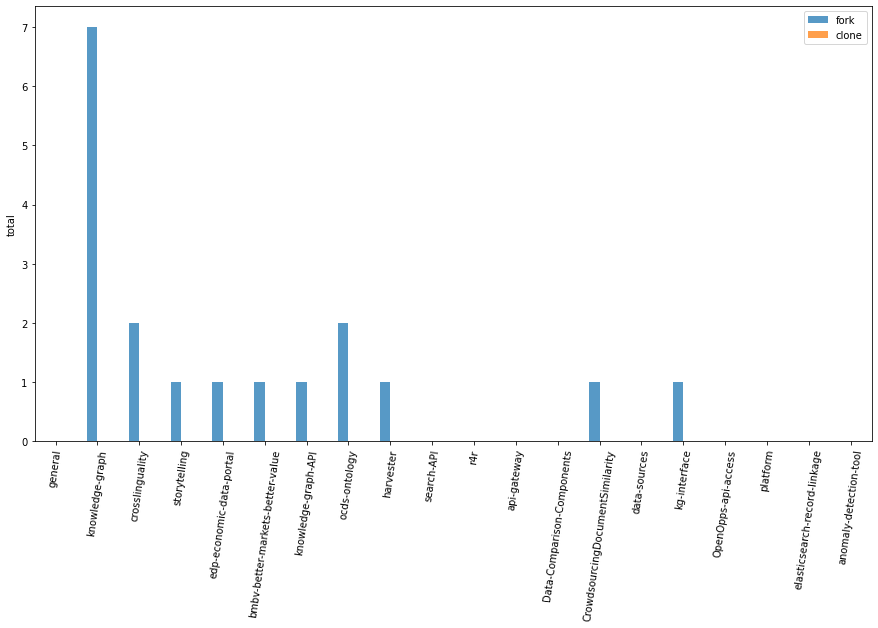

In [5]:
labels = [repo['name'] for repo in repos]

#watchers = [repos_info[repo['name']]['watchers_count'] for repo in repos]
forks = [repos_info[repo['name']]['forks_count'] for repo in repos]
#subscribers = [repos_info[repo['name']]['subscribers_count'] for repo in repos]
#stars = [repos_info[repo['name']]['stargazers_count'] for repo in repos]
downloads = [len(repos_download[repo['name']]) for repo in repos]


# dictionary of lists  
dict = {'repositories': labels, 'fork': forks, 'clone': downloads}  
    
df = pd.DataFrame(dict)
df.set_index("repositories",drop=True,inplace=True)

df.plot( kind= 'bar', alpha=0.75, rot= 82, figsize=(15,8) )
plt.xlabel("")
plt.ylabel("total")
plt.show()
